In [27]:
# This code is written to solve the hindi and Tamil Question - Answer task and will use seperate models to run for each Hindi and Tamil. I am using seq-to-seq  with attension model
# to output the answer for the input question in those two given languages
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import spacy
from spacy.lang.hi import Hindi 
from spacy.lang.ta import Tamil
from collections import Counter
from tqdm import tqdm_notebook
import random
import matplotlib.pyplot as plt

test = True  

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [28]:
#Encoder LSTM 
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
    super(EncoderLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)

  def forward(self, inputs, hidden):
    # Embed input words
    embedded = self.embedding(inputs)
    # Pass the embedded word vectors into LSTM and return all outputs
    output, hidden = self.lstm(embedded, hidden)
    return output, hidden

  def init_hidden(self, batch_size=1):
    return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

In [29]:
class BahdanauDecoder(nn.Module):
  def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
    super(BahdanauDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.drop_prob = drop_prob

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    
    self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
    self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.drop_prob)
    self.lstm = nn.LSTM(self.hidden_size*2, self.hidden_size, batch_first=True)
    self.classifier = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, inputs, hidden, encoder_outputs):
    encoder_outputs = encoder_outputs.squeeze()
    # Embed input words
    embedded = self.embedding(inputs).view(1, -1)
    embedded = self.dropout(embedded)

    # Calculating Alignment Scores
    x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
    alignment_scores = x.bmm(self.weight.unsqueeze(2))  
    
    # Softmaxing alignment scores to get Attention weights
    attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)
    
    # Multiplying the Attention weights with encoder outputs to get the context vector
    context_vector = torch.bmm(attn_weights.unsqueeze(0),
                             encoder_outputs.unsqueeze(0))
    
    # Concatenating context vector with embedded input word
    output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
    # Passing the concatenated vector as input to the LSTM cell
    output, hidden = self.lstm(output, hidden)
    # Passing the LSTM output through a Linear layer acting as a classifier
    output = F.log_softmax(self.classifier(output[0]), dim=1)
    #print(output)
    #        import sys; sys.exit()
    return output, hidden, attn_weights

In [74]:
data = pd.read_csv('train.csv')
questions = data['question']
answers = data['answer_text']
#Setting the number of training sentences we'll use
#training_examples = len(questions)
training_examples_hi = len(questions.loc[data['language']=='hindi'])
training_examples_ta = len(questions.loc[data['language']=='tamil'])

spacy_hi = Hindi()
spacy_ta = Tamil()
words_hi = Counter()
words_ta = Counter()


qu_inputs = []
an_inputs = []
for i in tqdm_notebook(range(training_examples_hi)):
    qu_tokens_hi = spacy_hi(questions.loc[data['language']=='hindi'].iloc[i])
    an_tokens_hi = spacy_hi(answers.loc[data['language']=='hindi'].iloc[i])
    if len(qu_tokens_hi)==0 or len(an_tokens_hi)==0:
        continue
    for qu_token in qu_tokens_hi:
        words_hi.update([qu_token.text])
    for an_token in an_tokens_hi:
        words_hi.update([an_token.text])
    qu_inputs.append([token.text for token in qu_tokens_hi] + ['_EOS'])
    an_inputs.append([token.text for token in an_tokens_hi] + ['_EOS'])

#Writing this part for hindi and tamil questions and answers of train set
words_hi_vocab = ['_SOS','_EOS','_UNK'] + sorted(words_hi,key=words_hi.get,reverse=True)
hi_w2i = {o:i for i,o in enumerate(words_hi_vocab)}
hi_i2w = {i:o for i,o in enumerate(words_hi_vocab)}

#Converting only Hindi sentences to their token indexes
qu_inputs_hi = []
an_inputs_hi = []
#print(words_hi_vocab)
for i in range(len(qu_inputs)):
    qu_sentence = qu_inputs[i]
    an_sentence = an_inputs[i]
    qu_inputs_hi.append([hi_w2i[word] for word in qu_sentence])
    an_inputs_hi.append([hi_w2i[word] for word in an_sentence])
                        
                        
qu_inputs = []
an_inputs = []
#Similarly tokenizing tamil quentions and answers
for i in tqdm_notebook(range(training_examples_ta)):
    qu_tokens_ta = spacy_ta(questions.loc[data['language']=='tamil'].iloc[i])
    an_tokens_ta = spacy_ta(answers.loc[data['language']=='tamil'].iloc[i])
    if len(qu_tokens_ta)==0 or len(an_tokens_ta)==0:
        continue
    for qu_token in qu_tokens_ta:
        words_ta.update([qu_token.text])
    for an_token in an_tokens_ta:
        words_ta.update([an_token.text])
    qu_inputs.append([token.text for token in qu_tokens_ta] + ['_EOS'])
    an_inputs.append([token.text for token in an_tokens_ta] + ['_EOS'])
    
    
words_ta_vocab = ['_SOS','_EOS','_UNK'] + sorted(words_ta,key=words_ta.get,reverse=True)
ta_w2i = {o:i for i,o in enumerate(words_ta_vocab)}
ta_i2w = {i:o for i,o in enumerate(words_ta_vocab)}
  
#Converting only Tamil sentences to their token indexes
qu_inputs_ta = []
an_inputs_ta = []
#print(words_hi_vocab)
for i in range(len(qu_inputs)):
    qu_sentence = qu_inputs[i]
    an_sentence = an_inputs[i]
    qu_inputs_ta.append([ta_w2i[word] for word in qu_sentence])
    an_inputs_ta.append([ta_w2i[word] for word in an_sentence])
    


#for test set
#qu_inputs
if test == True:
    qu_inputs_test_hi = []
    qu_inputs_test_ta = []
    data_test = pd.read_csv('test.csv')
    questions_test = data_test['question']
    #for test examples
    test_examples_hi = len(questions_test.loc[data_test['language']=='hindi'])
    test_examples_ta = len(questions_test.loc[data_test['language']=='tamil'])
    qu_inputs_hi_temp = []
    qu_inputs_ta_temp = []
    for i in tqdm_notebook(range(test_examples_hi)):
        qu_tokens_hi_test = spacy_hi(questions_test.loc[data_test['language']=='hindi'].iloc[i])
        qu_inputs_hi_temp.append([token.text for token in qu_tokens_hi_test] + ['_EOS'])
    #Similarly tokenizing tamil quentions
    for i in tqdm_notebook(range(test_examples_ta)):
        qu_tokens_ta_test = spacy_hi(questions_test.loc[data_test['language']=='tamil'].iloc[i])
        qu_inputs_ta_temp.append([token.text for token in qu_tokens_ta_test] + ['_EOS'])
    #writing indexes for Hindi and tamil test questions
    for i in range(len(qu_inputs_hi_temp)):
        qu_sentence = qu_inputs_hi_temp[i]
        qu_inputs_test_hi.append([hi_w2i[word] if words_hi[word] else hi_w2i['_UNK'] for word in qu_sentence])
    for i in range(len(qu_inputs_ta_temp)):
        qu_sentence = qu_inputs_ta_temp[i]
        qu_inputs_test_ta.append([ta_w2i[word] if words_ta[word] else ta_w2i['_UNK'] for word in qu_sentence])
    #For submission of test results on Kaggle
    sub = pd.read_csv('sample_submission.csv')
    pred_id_hi = data_test['id'].loc[data_test['language'] == 'hindi'].reset_index()
    pred_id_ta = data_test['id'].loc[data_test['language'] == 'tamil'].reset_index()

<ipython-input-74-327c122c6a3c>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(training_examples_hi)):


  0%|          | 0/746 [00:00<?, ?it/s]

<ipython-input-74-327c122c6a3c>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(training_examples_ta)):


  0%|          | 0/368 [00:00<?, ?it/s]

<ipython-input-74-327c122c6a3c>:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(test_examples_hi)):


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-74-327c122c6a3c>:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(test_examples_ta)):


  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
#Writing for hindi training model and then testing
hidden_size = 256
encoder = EncoderLSTM(len(words_hi), hidden_size).to(device)
#attn = Attention(hidden_size,"concat")
#decoder = LuongDecoder(hidden_size,len(words_hi),attn).to(device)
decoder = BahdanauDecoder(hidden_size,len(words_hi)).to(device)
lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
EPOCHS = 10
teacher_forcing_prob = 0.5
encoder.train()
decoder.train()
tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)
for epoch in tk0:
    avg_loss = 0.
    tk1 = tqdm_notebook(enumerate(qu_inputs_hi[0:len(qu_inputs_hi)-1]),total=len(qu_inputs_hi)-1,leave=False)
    for i, sentence in tk1:
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        #print(sentence)
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)
        #print(encoder_outputs)
        #First decoder input will be the SOS token
        decoder_input = torch.tensor([hi_w2i['_SOS']],device=device)
        #First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        teacher_forcing = True if random.random() < teacher_forcing_prob else False
        
        for ii in range(len(an_inputs_hi[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Get the index value of the word with the highest score from the decoder output
            #print(decoder_output)
            top_value, top_index = decoder_output.topk(1)
            if teacher_forcing:
                decoder_input = torch.tensor([an_inputs_hi[i][ii]],device=device)
            else:
                decoder_input = torch.tensor([top_index.item()],device=device)
            output.append(top_index.item())
            #Calculate the loss of ?the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([an_inputs_hi[i][ii]],device=device))
            #print(loss)
            #import sys; sys.exit()
        loss = loss/len(an_inputs_hi[i])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        avg_loss += loss.item()/len(qu_inputs_hi)
    tk0.set_postfix(loss=avg_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),"d_optimizer":decoder_optimizer},"./model.pt")

<ipython-input-31-c9728a052c09>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-31-c9728a052c09>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk1 = tqdm_notebook(enumerate(qu_inputs_hi[0:len(qu_inputs_hi)-1]),total=len(qu_inputs_hi)-1,leave=False)


  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]

Hindi: _UNK _UNK की माँ का नाम क्या है _UNK
Answer Predicted: "
Hindi: _UNK _UNK कब लॉन्च किया गया था ? _UNK
Answer Predicted: 15 दिसम्बर
Hindi: गुस्ताव _UNK का जन्म कब हुआ था ? _UNK
Answer Predicted: 15 अप्रैल 1469


<ipython-input-78-2635531f4115>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+[hi_i2w[x] for x in qu_inputs_test_hi[i]])
<ipython-input-78-2635531f4115>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+[hi_i2w[x] for x in output])


NameError: name 'ticker' is not defined

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s

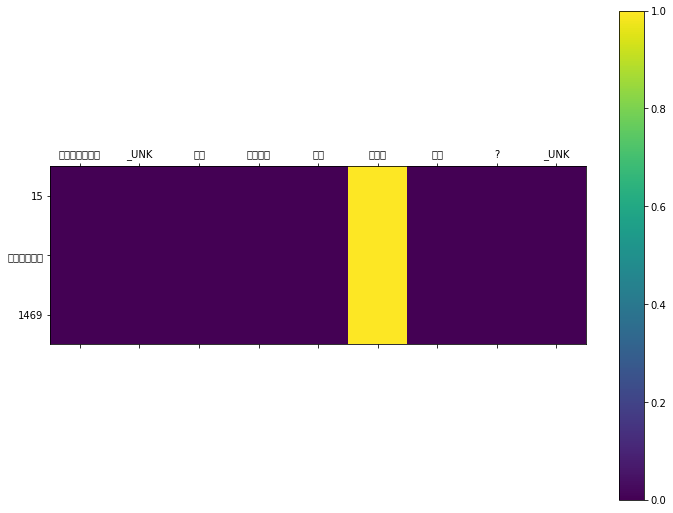

In [78]:
if test == True:
    encoder.eval()
    decoder.eval()
    #
    #i = random.randint(0,len(qu_inputs_test_hi)-1)
    #Doing for all hindi sentences
    for i in range(len(qu_inputs_test_hi)):
        h = encoder.init_hidden()
        inp = torch.tensor(qu_inputs_test_hi[i]).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)

        decoder_input = torch.tensor([hi_w2i['_SOS']],device=device)
        decoder_hidden = h
        output = []
        attentions = []
        while True:
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, top_index = decoder_output.topk(1)
            decoder_input = torch.tensor([top_index.item()],device=device)
            #If the decoder output is the End Of Sentence token, stop decoding process
            if top_index.item() == hi_w2i["_EOS"]:
                break
            output.append(top_index.item())
            attentions.append(attn_weights.squeeze().cpu().detach().numpy())
        in_string = " ".join([hi_i2w[x] for x in qu_inputs_test_hi[i]])
        out_string = " ".join([hi_i2w[x] for x in output])
        print("Hindi: "+ in_string)
        print("Answer Predicted: " + out_string)
        sub['PredictionString'].loc[sub['id'] == pred_id_hi['id'][i]] = out_string
    #Plotting the heatmap for the Attention weights
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.array(attentions))
    fig.colorbar(cax)
    ax.set_xticklabels(['']+[hi_i2w[x] for x in qu_inputs_test_hi[i]])
    ax.set_yticklabels(['']+[hi_i2w[x] for x in output])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [5]:
#Writing for tamil training model  and testing
hidden_size = 256
encoder = EncoderLSTM(len(words_ta), hidden_size).to(device)
#attn = Attention(hidden_size,"concat")
#decoder = LuongDecoder(hidden_size,len(words_hi),attn).to(device)
decoder = BahdanauDecoder(hidden_size,len(words_ta)).to(device)
lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
EPOCHS = 10
teacher_forcing_prob = 0.5
encoder.train()
decoder.train()
tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)
for epoch in tk0:
    avg_loss = 0.
    tk1 = tqdm_notebook(enumerate(qu_inputs_ta[0:len(qu_inputs_ta)-2]),total=len(qu_inputs_ta)-2,leave=False)
    for i, sentence in tk1:
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        #print(sentence)
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)
        #print(encoder_outputs)
        #First decoder input will be the SOS token
        decoder_input = torch.tensor([ta_w2i['_SOS']],device=device)
        #First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        teacher_forcing = True if random.random() < teacher_forcing_prob else False
        
        for ii in range(len(an_inputs_ta[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Get the index value of the word with the highest score from the decoder output
            #print(decoder_output)
            top_value, top_index = decoder_output.topk(1)
            if teacher_forcing:
                decoder_input = torch.tensor([an_inputs_ta[i][ii]],device=device)
            else:
                decoder_input = torch.tensor([top_index.item()],device=device)
            output.append(top_index.item())
            #Calculate the loss of ?the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([an_inputs_ta[i][ii]],device=device))
            #print(loss)
            #import sys; sys.exit()
        loss = loss/len(an_inputs_ta[i])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        avg_loss += loss.item()/len(qu_inputs_ta)
    tk0.set_postfix(loss=avg_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),"d_optimizer":decoder_optimizer},"./model_ta.pt")

<ipython-input-5-b3cb5e4635e4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-5-b3cb5e4635e4>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk1 = tqdm_notebook(enumerate(qu_inputs_ta[0:len(qu_inputs_ta)-2]),total=len(qu_inputs_ta)-2,leave=False)


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

Tamil: _UNK அணு எண் என்ன ? _UNK
Answer Predicted: மண்டேலா உலகில் ரகுமான் சார்லஸ்
Tamil: இந்தியாவில் _UNK _UNK தந்தை என்று கருதப்படுபவர் யார் ? _UNK
Answer Predicted: மண்டேலா உலகில் ரகுமான்


<ipython-input-76-ef5a0434807f>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+[ta_i2w[x] for x in qu_inputs_test_ta[i]])
<ipython-input-76-ef5a0434807f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+[ta_i2w[x] for x in output])


NameError: name 'ticker' is not defined

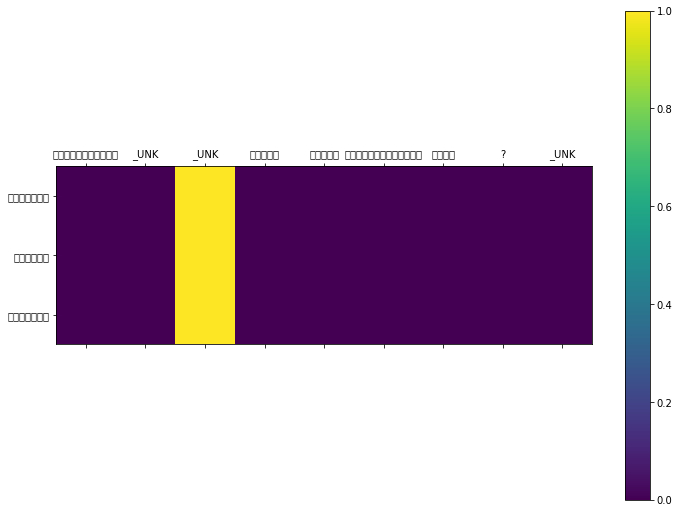

In [76]:
if test == True:   
    encoder.eval()
    decoder.eval()
    #Choose a random sentences
    #i = random.randint(0,len(qu_inputs_test_ta)-1)
    #Doing decoding for all tamil sentences
    for i in range(len(qu_inputs_test_ta)):
        h = encoder.init_hidden()
        inp = torch.tensor(qu_inputs_test_ta[i]).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)

        decoder_input = torch.tensor([ta_w2i['_SOS']],device=device)
        decoder_hidden = h
        output = []
        attentions = []
        while True:
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, top_index = decoder_output.topk(1)
            decoder_input = torch.tensor([top_index.item()],device=device)
            #If the decoder output is the End Of Sentence token, stop decoding process
            if top_index.item() == ta_w2i["_EOS"]:
                break
            output.append(top_index.item())
            attentions.append(attn_weights.squeeze().cpu().detach().numpy())
        in_string = " ".join([ta_i2w[x] for x in qu_inputs_test_ta[i]])
        out_string = " ".join([ta_i2w[x] for x in output])
        print("Tamil: "+ in_string)
        print("Answer Predicted: " + out_string)
        sub['PredictionString'].loc[sub['id'] == pred_id_ta['id'][i]] = out_string
    #Plotting the heatmap for the Attention weights
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.array(attentions))
    fig.colorbar(cax)
    ax.set_xticklabels(['']+[ta_i2w[x] for x in qu_inputs_test_ta[i]])
    ax.set_yticklabels(['']+[ta_i2w[x] for x in output])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [80]:
#Saving to sample submission csv file
sub.to_csv('sample_submission.csv')